In [1]:
import pandas as pd
data = pd.read_csv("data/file.csv", encoding='latin-1')
object_columns = data.select_dtypes(include='object').columns
data_1 = pd.get_dummies(data= data, columns=object_columns)

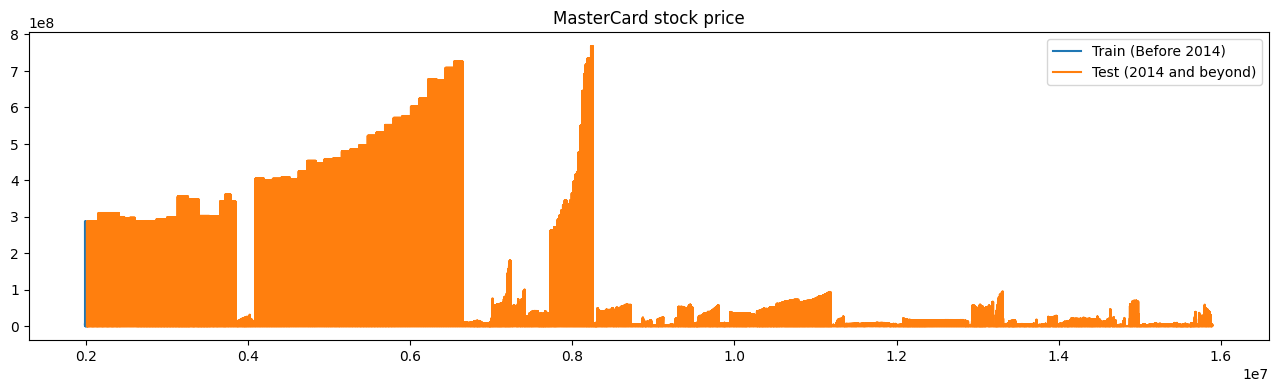

In [2]:
import matplotlib.pyplot as plt

tstart = 1990
tend = 2010

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "yield_amound"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "yield_amound"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(data_1,tstart,tend)

In [3]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "yield_amound"].values
    test = dataset.loc[f"{tend+1}":, "yield_amound"].values
    return train, test
training_set, test_set = train_test_split(data_1, tstart, tend)

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [5]:

import numpy as np

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [6]:
import numpy as np
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
717/717 [==============================] - 29s 36ms/step - loss: 0.0017
Epoch 2/50
717/717 [==============================] - 27s 38ms/step - loss: 9.8487e-04
Epoch 3/50
717/717 [==============================] - 27s 38ms/step - loss: 8.9684e-04
Epoch 4/50
717/717 [==============================] - 27s 37ms/step - loss: 8.4659e-04
Epoch 5/50
717/717 [==============================] - 26s 37ms/step - loss: 8.2112e-04
Epoch 6/50
717/717 [==============================] - 27s 38ms/step - loss: 8.0575e-04
Epoch 7/50
717/717 [==============================] - 27s 37ms/step - loss: 7.9247e-04
Epoch 8/50
717/717 [==============================] - 28s 39ms/step - loss: 7.8266e-04
Epoch 9/50
717/717 [==============================] - 27s 38ms/step - loss: 7.8109e-04
Epoch 10/50
717/717 [==============================] - 27s 37ms/step - loss: 7.7724e-04
Epoch 11/50
717/717 [==============================] - 28s 40ms/step - loss: 7.7261e-04
Epoch 12/50
717/717 [========================

In [8]:
dataset_total = data_1.loc[:,"yield_amound"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

149782/433720 [=========>....................] - ETA: 4:13:41

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Year")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

In [ ]:
data_1

,Year,avg_temp,yield_amound,pesticide_amound,Area_Albania,Area_Algeria,Area_Angola,Area_Argentina,Area_Australia,Area_Austria,...,Item_y_Seed Treat Fung Ã¢ÂÂ Benzimidazoles,Item_y_Seed Treat Fung Ã¢ÂÂ Botanical products and biologicals,Item_y_Seed Treat Fung Ã¢ÂÂ Dithiocarbamates,Item_y_Seed Treat Fung Ã¢ÂÂ Other,"Item_y_Seed Treat Fung Ã¢ÂÂ Triazoles, diazoles",Item_y_Seed Treat Insect Ã¢ÂÂ Carbamates,Item_y_Seed Treat Insect Ã¢ÂÂ Organo-phosphates,Item_y_Seed Treat Insect Ã¢ÂÂ Other,Item_y_Seed Treat Insect Ã¢ÂÂ Pyrethroids,Unit_y_tonnes
0,1990,26.73,843800.00,65.8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1990,26.73,843800.00,32.4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1990,26.73,843800.00,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1990,26.73,843800.00,25.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1990,26.73,843800.00,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64731,2013,20.73,86599.74,9.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
64732,2013,20.73,86599.74,17.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
64733,2013,20.73,86599.74,18.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
64734,2013,20.73,86599.74,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


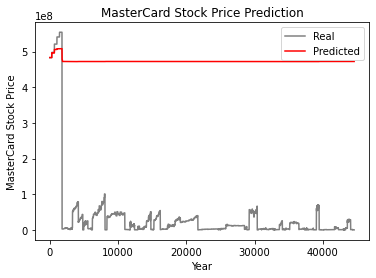

In [ ]:
plot_predictions(test_set,predicted_stock_price)